In [1]:
#Importing the data frames 

import pandas as pd
from fuzzywuzzy import process, fuzz

flanker = pd.read_excel("flanker.xlsx")
survey = pd.read_excel('survey.xlsx')

/opt/anaconda3/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
#Joining the data for both tasks

# Convert the ID columns to lowercase
survey['IDkoda'] = survey['IDkoda'].astype(str).str.lower()
flanker['subjectId'] = flanker['subjectId'].astype(str).str.lower()

# Perform the merge using exact match
result = pd.merge(survey, flanker, left_on='IDkoda', right_on='subjectId', how='inner')
result = result[result['IDkoda'].notna() & result['subjectId'].notna()]



In [3]:
# Create a function to find the best match
def match_ids(row, flanker_df):
    subject_id = row['IDkoda']
    # Handle empty or NaN values
    if pd.isna(subject_id) or not isinstance(subject_id, str):
        return None
    # Use fuzzy matching to find the best match with a cutoff of 90%
    match = process.extractOne(subject_id, flanker_df['subjectId'], scorer=fuzz.partial_ratio, score_cutoff=90)
    if match:
        return match[0]
    return None

# Apply the function to create a new column in the survey DataFrame with the matched subjectId
survey_df=survey
survey_df['matched_subjectId'] = survey_df.apply(match_ids, axis=1, flanker_df=flanker)

# Filter out rows where no match was found
survey_df = survey_df[survey_df['matched_subjectId'].notna()]
# Filter out rows where no match was found or where the matched ID is 'nan'
survey_df = survey_df[survey_df['matched_subjectId'].notna() & (survey_df['matched_subjectId'] != 'NaN')]

# Merge the dataframes on the matched subjectId
result_df = pd.merge(survey_df, flanker, left_on='matched_subjectId', right_on='subjectId', how='left')

# Explicitly filter out rows with NaN values in critical columns after merge and equal abcd1234 (too many matches)
result_df = result_df[result_df['IDkoda'].notna() & result_df['subjectId'].notna()]
result_df = result_df[(result_df['IDkoda']!= 'NaN') & (result_df['subjectId'] != 'NaN')]
result_df = result_df[result_df['matched_subjectId'] != 'abcd123']


# Find fuzzy matches that are not exact
fuzzy_matches = result_df[~result_df['IDkoda'].isin(result['IDkoda'])]


# Print fuzzy matches that are not exact
print("\nFuzzy Matches (not exact):")
print(fuzzy_matches[['IDkoda', 'matched_subjectId']])
fuzzy = fuzzy_matches[['IDkoda', 'matched_subjectId']]


Fuzzy Matches (not exact):
       IDkoda matched_subjectId
0      1s2e3d           1s2e3dm
28        k22           kkkk222
32     443tja           443tjas
33         23           523mgbb
37   mars2011           mars201
39    232vodn           323vodn
47   tsai3788           tsai378
57      ajna8           ajna888
58      ajna8           ajna888
64     333rdd           333rddd
69     123nmm           123nmmm
73   gopa8001           gopa800
89       2108           2108abc
120  mars2011           mars201
128    m1v2a3           m1v2a3.


In [4]:
result_df.columns

Index(['included', 'IDkoda', 'not equal', 't_insert', 't_edit', 'status',
       'SEX', 'AGE', 'Q2', 'Q3', 'Q4', 'Q5', 'Q9_2', 'Q6', 'Q8', 'Q9', 'Q7a',
       'Q7b', 'Perception of time on all social media', 'Other social media',
       'Instagram perception', 'TikTok perception', 'FB perception',
       'whatsApp perception', 'LinkedIn perception', 'Twitter perception',
       'Youtube perception', 'Snapchat perception', 'Threads perception',
       'Pinterest perception', 'other perception',
       'time spend on all social media apps actual', 'Instagram actual',
       'TikTok actual', 'FB actual', 'whatsApp actual', 'LinkedIn actual',
       'Twitter actual', 'Youtube actual', 'Snapchat actual', 'Threads actual',
       'Pinterest actual', 'other actual', 'matched_subjectId', 'subjectId',
       'elapsedTime', 'completed', 'percenterrors', 'meanRT',
       'percenterrors_c', 'meanrt_c', 'percenterrors_ic', 'meanrt_ic',
       'outliers', 'CII_ACC', 'CII_RT'],
      dtype='object')

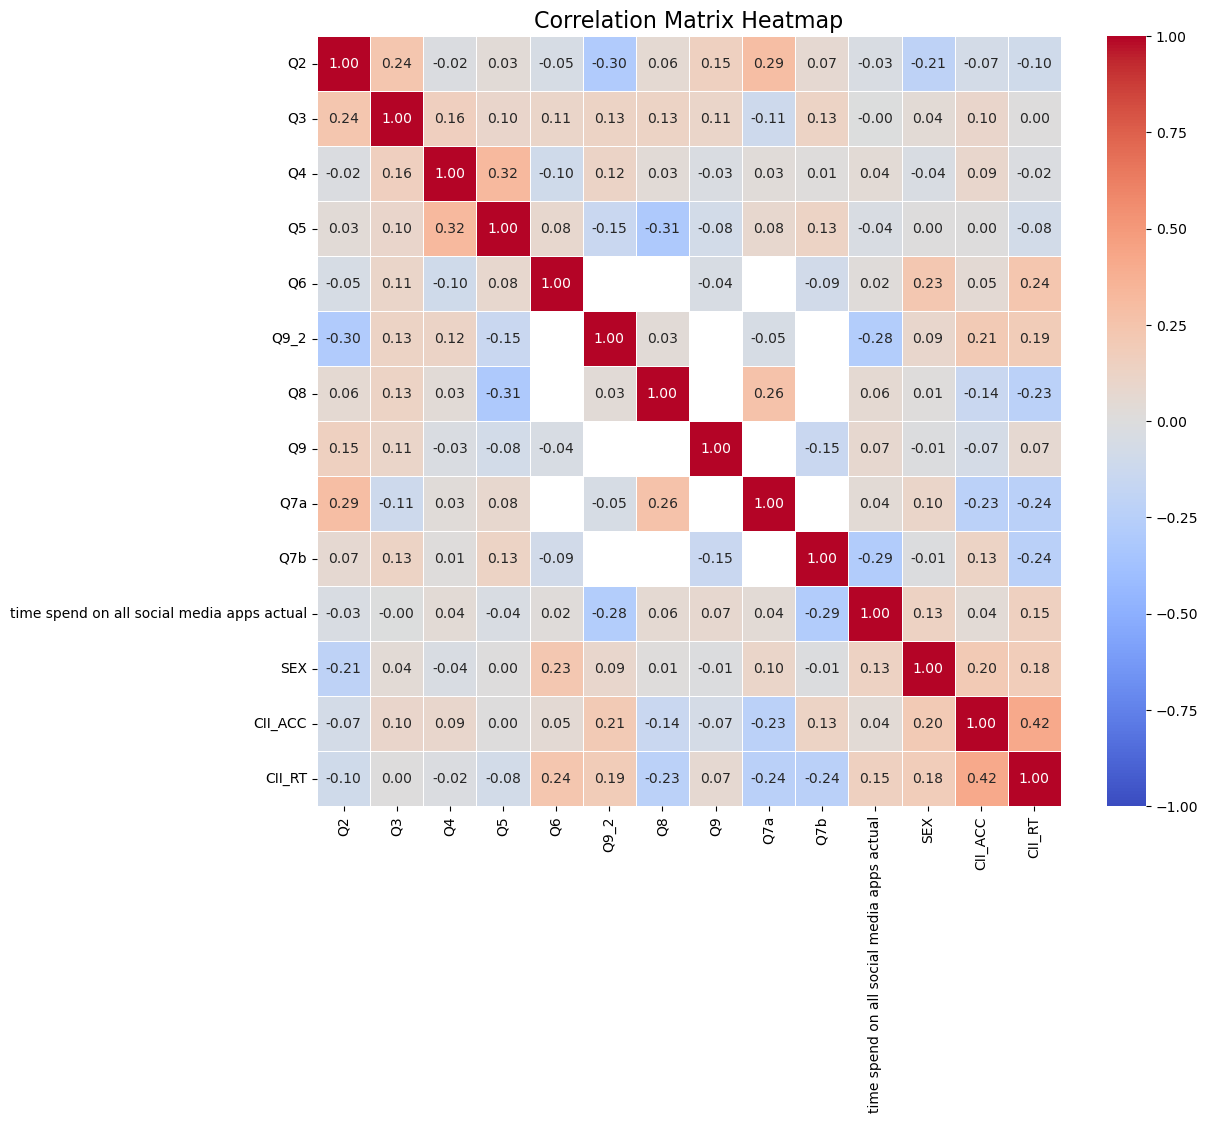

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation = result_df[['Q2','Q3','Q4','Q5','Q6','Q9_2','Q8','Q9','Q7a','Q7b' ,'time spend on all social media apps actual','SEX','CII_ACC', 'CII_RT']].corr()
correlation

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap with the correlation matrix
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

# Set plot title and labels
plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.show()